In [2]:
import MySQLdb
import sshtunnel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
import scipy.stats as stats
import random

In [3]:
sshtunnel.SSH_TIMEOUT = 5.0
sshtunnel.TUNNEL_TIMEOUT = 5.0

with sshtunnel.SSHTunnelForwarder(
    ('ssh.pythonanywhere.com'),
    ssh_username='Grawi', ssh_password='midgeq-xikFah-gukpu7',
    remote_bind_address=('Grawi.mysql.pythonanywhere-services.com', 3306)
) as tunnel:
    print("Successfully connected to Pythonanywhere")
    connection = MySQLdb.connect(
        user='Grawi',
        passwd='david2202087',
        host='127.0.0.1', port=tunnel.local_bind_port,
        db='Grawi$Interactive_quiz_database',
    )
    # Do stuff
    print("Successfully connected to database")
    
    try:
        cursor = connection.cursor()
        df = [None, None, None]
        df[0] = pd.read_sql("SELECT * FROM condition_1;", connection)
        df[1] = pd.read_sql("SELECT * FROM condition_2;", connection)
        df[2] = pd.read_sql("SELECT * FROM condition_3;", connection)
        print(f"Data read finished, length: condition 1 length {len(df[0])}, condition 2 length {len(df[1])}, condition 3 length {len(df[2])}")
    except Exception as e:
        print("Error:", e)
    
    finally:
        # Close the cursor and connection
        cursor.close()
        connection.close()

Successfully connected to Pythonanywhere
Successfully connected to database
Data read finished, length: condition 1 length 99, condition 2 length 40, condition 3 length 40


### Attention Pass Check

In [4]:
for i in range(3):
    df[i]['additional_answers'] = df[i]['additional_answers'].apply(literal_eval)
    df[i]['non_ideology_answers'] = df[i]['non_ideology_answers'].apply(literal_eval)
    try:
        if hasattr(df[i], 'ideology_answers'):
            df[i]['ideology_answers'] = df[i]['ideology_answers'].apply(literal_eval)
    except:
        None
    if hasattr(df[i], 'labels'):
        df[i]['labels'] = df[i]['labels'].apply(literal_eval)

In [5]:
for i in range(3):
    id_attention_failed = df[i][df[i]['attention_passed'] == 0]['participantId'].tolist()
    print(f"For condition {i + 1}, {len(id_attention_failed)} participants failed attention passed: {id_attention_failed}")
    df[i] = df[i][df[i]['attention_passed'] == True]
    columns_to_drop = ['assignmentId', 'projectId', 'attention_passed', 'total_time', 'identity_choices', 'ideologies', 'submit_time']
    df[i].drop(columns_to_drop, inplace=True, axis=1)
    print(f"There are {len(df[i])} valid data collected\n")
    df[i].set_index('participantId', inplace=True)
df[0].head()

For condition 1, 3 participants failed attention passed: ['363DEB2413FB48FD9D4CDCFD0EFE8171', '60B62D2058D24418965396147B2746C3', 'F5F966E8A63F467E9ABC254186478292']
There are 96 valid data collected

For condition 2, 1 participants failed attention passed: ['9FF5D3BF714E4790AA2D2CEE3F99C74E']
There are 39 valid data collected

For condition 3, 2 participants failed attention passed: ['54595FC00C524A20A878732C39D73930', 'B92685A472A94FBAB03D1F9ED4A86FA0']
There are 38 valid data collected



,bot_detected,non_ideology_answers,additional_answers,reason
participantId,,,,
077EBB20179F4DDF9DA032AF2B7EE4F4,30,"[{'answers': [-100, 2.1, -100], 'time_to_answe...","[[1, -1.7, -1]]",I just thought it was too inconvenie of a time...
08118FE4A7504A34B93DEC7B88ED4EB6,66,"[{'answers': [-100, 1.5500000000000007, -100],...","[[-0.2, 0.7, -0.4]]",
0AA37D5D01BA4B76A3FF64C0B1F49B70,66,"[{'answers': [-100, 1.1, -100], 'time_to_answe...","[[0.6, 0.2, -0.2]]",None
0B8D09A73ED140CF84C5320DAE27F350,50,"[{'answers': [-100, -3, -100], 'time_to_answer...","[[1, 2, 1]]",None
0B97FA950789450AA070261124D188E7,33,"[{'answers': [-100, 1.666666666666667, -100], ...","[[0.1, -0.1, 0.3]]",I just assume that they are bots based on how ...


### Bot detection

In [6]:
def get_bot_detection_num(detection):
    first = detection // 10
    second = detection % 10
    return int(first == 3) + int(second == 3)

ratio_at_least_one_bot_detected = []
ratio_one_bot_detected = []
ratio_two_bots_detected = []

for i in range(3):
    df[i]['bot_detection_num'] = df[i]['bot_detected'].apply(get_bot_detection_num)
    ratio_at_least_one_bot_detected.append(((df[i]['bot_detection_num'] >= 1).sum()) / (len(df[i])))
    ratio_one_bot_detected.append(((df[i]['bot_detection_num'] == 1).sum()) / (len(df[i])))
    ratio_two_bots_detected.append(((df[i]['bot_detection_num'] == 2).sum()) / (len(df[i])))
    print(f"For condition {i + 1}, there are {ratio_at_least_one_bot_detected[i]:.2%} participants who detected at least one bot")
    print(f"For condition {i + 1}, there are {ratio_one_bot_detected[i]:.2%} participants who detected one bot")
    print(f"For condition {i + 1}, there are {ratio_two_bots_detected[i]:.2%} participants who detected at two bots")
    df[i].drop(['reason', 'bot_detection_num'], axis=1, inplace=True)

For condition 1, there are 37.50% participants who detected at least one bot
For condition 1, there are 18.75% participants who detected one bot
For condition 1, there are 18.75% participants who detected at two bots
For condition 2, there are 28.21% participants who detected at least one bot
For condition 2, there are 12.82% participants who detected one bot
For condition 2, there are 15.38% participants who detected at two bots
For condition 3, there are 21.05% participants who detected at least one bot
For condition 3, there are 2.63% participants who detected one bot
For condition 3, there are 18.42% participants who detected at two bots


### Labels

1. If given lables are valid (E.g. Liberal and Conservative shouldn't be given simultaneously to one participant)
2. How many ideology-related labels are given
3. How many SCM-related labels are given
4. How 2 and 3 are correlated

In [7]:
validity_level = 3
print(f"Validity Level {validity_level}")

def labels_are_valid(labels):
    for idx, each_participant_labels in enumerate(labels):
        labels_set = set(each_participant_labels)
        if len(set([0, 1, 2, 3]).intersection(labels_set)) >= 2:
            return False
        if len(set([4, 5]).intersection(labels_set)) >= 2:
            return False
        if len(set([6, 7]).intersection(labels_set)) >= 2:
            return False
        if len(set([8, 9]).intersection(labels_set)) >= 2:
            return False
        
        if validity_level >= 2:
            if len(set([0, 1, 2, 3]).intersection(labels_set)) == 0:
                return False

        if validity_level == 3:
            if idx == 0 and len(set([2, 3]).intersection(labels_set)) == 0:
                return False
            if idx == 2 and len(set([0, 1]).intersection(labels_set)) == 0:
                return False

    return True

for i in [1, 2]:
    df[i]['labels_are_valid'] = df[i]['labels'].apply(labels_are_valid)

print(f"{df[1]['labels_are_valid'].mean():.2%} percent of labels in condition 2 are valid, {df[2]['labels_are_valid'].mean():.2%} percent of labels in condition 3 are valid.")

df_label = [None, None, None]
print(f"Data with invalid labels have been dropped:")
for i in [1, 2]:
    print(f"Condition {i + 1}, ID: {df[i][df[i]['labels_are_valid'] == False].index.tolist()}")
    df_label[i] = df[i][df[i]['labels_are_valid'] == True]
    df[i] = df[i].drop(['labels_are_valid'], axis=1)
df_label[0] = df[0]

Validity Level 3
61.54% percent of labels in condition 2 are valid, 55.26% percent of labels in condition 3 are valid.
Data with invalid labels have been dropped:
Condition 2, ID: ['09DE52E0D4FA438FA7604C64DC26BC1B', '21CC1F4A3630480AAC403B2C1BD514C5', '286568B59A454BF6B4AA082A1DD1AE2D', '2B7B8F8CD02F4897BEAD0D0ABE5A097E', '4228725B2E8548CEB7D8A48CB40A69AA', '4F666DDEF59140568082EC4FB22FF502', '5384CB299B464A7CB132B9B39E0AC593', '67E4F319881D4A1385137B4B7688A1DC', '72C0AC763269475093B48A6679BA44CA', '7ADA866FE462485AB338CB2D870F0FD3', '8956002BB45846F48239770F19468A5F', '9934667B8A0B44CB852BD9F3F9A4B353', 'A50C3A2098BE40928A52C4CFABD4F548', 'B719D9B07581427DA0B950C58EBDC4CE', 'E5DA6503EE474B408634698923790E8D']
Condition 3, ID: ['0870B39E7CB348DBB74699311458D574', '15FB8938DB8B4885A5A995ABADB04697', '27ED3E8F26C24F599DFB267D141BC0EF', '33AA135E2637478D90D198D800055C1D', '48336A322C2247CBA0D3135FC778C18E', '5D5820374DC04680AAA6E5263110631B', '728CBAB7EEA248528C4AAAED320F538F', '86AA240E

## Compare Average Distances and Plot The Figure

In [8]:
each_answer = [None, None, None]
for i in range(3):
    each_answer[i] = df_label[i].explode('non_ideology_answers')
    each_answer[i]['answers'] = each_answer[i].apply(lambda row: row['non_ideology_answers']['answers'], axis=1)
    each_answer[i]['idx_of_question'] = each_answer[i].apply(lambda row: row['non_ideology_answers']['idx_of_question'], axis=1)
    each_answer[i]['who_answers_first'] = each_answer[i].apply(lambda row: row['non_ideology_answers']['who_answers_first'], axis=1)
    each_answer[i].drop(['non_ideology_answers'], axis=1, inplace=True)

In [9]:
def detect_first_answering_bot(row):
    if row['who_answers_first'] == 0:
        return (row['bot_detected'] // 10) == 3
    else:
        return (row['bot_detected'] % 10) == 3

def get_ideology_dis(row):
    additional_answers = row['additional_answers'][0]
    return abs(additional_answers[row['who_answers_first']] - additional_answers[1])

def has_ideology_label(row):
    labels = row['labels'][row['who_answers_first']]
    if len(set([0, 1, 2, 3]).intersection(set(labels))) > 0:
        return True
    return False

def has_SCM_label(row):
    labels = row['labels'][row['who_answers_first']]
    if len(set([4, 5]).intersection(set(labels))) > 0 or len(set([8, 9]).intersection(set(labels))) > 0:
        return True
    return False

for i in range(3):
    each_answer[i]['detect_first_answering_bot'] = each_answer[i].apply(detect_first_answering_bot, axis=1)
    each_answer[i].drop(['bot_detected'], inplace=True, axis=1)
    each_answer[i]['ideology_distance'] = each_answer[i].apply(get_ideology_dis, axis=1)
    each_answer[i].drop(['additional_answers'], axis=1, inplace=True)

for i in [1, 2]:
    each_answer[i]['has_ideology_label'] = each_answer[i].apply(has_ideology_label, axis=1)
    each_answer[i]['has_SCM_label'] = each_answer[i].apply(has_SCM_label, axis=1)
    each_answer[i].drop(['ideology_answers', 'labels'], axis=1, inplace=True)

In [10]:
print(f"{each_answer[1]['has_ideology_label'].mean():.2%} participants in condition 2 are labeled with ideology-related labels, {each_answer[2]['has_ideology_label'].mean():.2%} in condition 3.")
print(f"{each_answer[1]['has_SCM_label'].mean():.2%} participants in condition 2 are labeled with SCM-related labels, {each_answer[2]['has_SCM_label'].mean():.2%} in condition 3.")

100.00% participants in condition 2 are labeled with ideology-related labels, 100.00% in condition 3.
63.89% participants in condition 2 are labeled with SCM-related labels, 60.32% in condition 3.


### Control 1: For condition 123, get the average answer distance when human answers first

In [11]:
simulation_times = 100
human_first_answer_distances = []

def calculate_answer_distance(row):
    if row['who_answers_first'] == 0 or row['who_answers_first'] == 2:
        return abs(row['answers'][1] - row['answers'][row['who_answers_first']])
    else:
        return abs(row['answers'][1] - (random.random() * 6 - 3))

for _ in range(simulation_times):
    for i in range(3):
        each_answer[i]['answer_distance'] = each_answer[i].apply(calculate_answer_distance, axis=1)
        human_first_answer_distances += each_answer[i]['answer_distance'][each_answer[i]['who_answers_first'] == 1].tolist()
    
human_first_answer_distance = sum(human_first_answer_distances) / len(human_first_answer_distances)
print(f"If human answers first, the average answer distance is {human_first_answer_distance:.3f} ({int(len(human_first_answer_distances) / simulation_times)} data points)")

If human answers first, the average answer distance is 2.084 (282 data points)


### Control 2: For condition 1, get the average answer distance when bot answers first, differentiating bot detection

In [12]:
bot_first_answer_distance = each_answer[0]['answer_distance'][each_answer[0]['who_answers_first'] != 1].mean()
bot_first_not_detected_answer_distance = each_answer[0]['answer_distance'][(each_answer[0]['who_answers_first'] != 1) & (each_answer[0]['detect_first_answering_bot'])].mean()
bot_first_detected_answer_distance = each_answer[0]['answer_distance'][(each_answer[0]['who_answers_first'] != 1) & (~each_answer[0]['detect_first_answering_bot'])].mean()
print(f"If bot answers first, the average answer distance is {bot_first_answer_distance:.3f}")
print(f"If bot is detected, it's {bot_first_detected_answer_distance:.3f}, else it's {bot_first_not_detected_answer_distance:.3f}")

If bot answers first, the average answer distance is 1.759
If bot is detected, it's 1.704, else it's 1.900


In [13]:
# calculate separately for each question
bot_first_each_answer = each_answer[0][each_answer[0]['who_answers_first'] != 1]
each_answer_grouped = bot_first_each_answer.groupby("idx_of_question")
each_answer_grouped['answer_distance'].mean()

idx_of_question
0    1.825000
1    1.952830
2    1.723148
3    1.800000
4    1.415942
5    1.900000
Name: answer_distance, dtype: float64

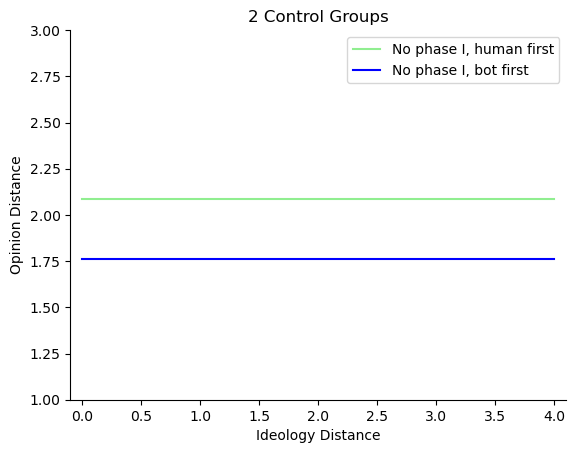

In [14]:
def plot_figure_when_bot_answers_first(each_answer, ax, color, label=None, display_scatter=False):
    bot_answers_first_c2 = each_answer['who_answers_first'] != 1
    bot_first_answer_distances_c2 = each_answer['answer_distance'][bot_answers_first_c2].tolist()
    bot_first_ideology_distances_c2 = each_answer['ideology_distance'][bot_answers_first_c2].tolist()
    m_c2, b_c2 = np.polyfit(x=bot_first_ideology_distances_c2, y=bot_first_answer_distances_c2, deg=1)
    regression_line_x = np.linspace(0, 4, 100)
    regression_line_y_c2 = m_c2 * regression_line_x + b_c2
    if display_scatter:
        ax.scatter(x=bot_first_ideology_distances_c2, y=bot_first_answer_distances_c2, color=color, s=5)
    ax.plot(regression_line_x, regression_line_y_c2, color=color, label=label)

fig, ax = plt.subplots()
ax.set_xlim(-0.1, 4.1)
ax.set_ylim(1, 3)

ax.plot([0, 4], [human_first_answer_distance, human_first_answer_distance], color='lightgreen', label="No phase I, human first")
ax.plot([0, 4], [bot_first_answer_distance, bot_first_answer_distance], color='blue', label="No phase I, bot first")

ax.set_title('2 Control Groups')
ax.set_xlabel('Ideology Distance')
ax.set_ylabel('Opinion Distance')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
plt.show()

### Experiment 12: For condition 23, get the average answer distance when bot answers first regarding ideology distance

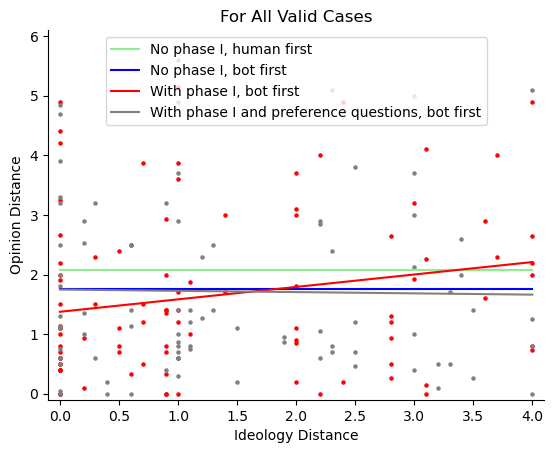

In [17]:
def plot_figure_when_bot_answers_first(each_answer, ax, color, label=None, display_scatter=False):
    bot_answers_first_c2 = each_answer['who_answers_first'] != 1
    bot_first_answer_distances_c2 = each_answer['answer_distance'][bot_answers_first_c2].tolist()
    bot_first_ideology_distances_c2 = each_answer['ideology_distance'][bot_answers_first_c2].tolist()
    m_c2, b_c2 = np.polyfit(x=bot_first_ideology_distances_c2, y=bot_first_answer_distances_c2, deg=1)
    regression_line_x = np.linspace(0, 4, 100)
    regression_line_y_c2 = m_c2 * regression_line_x + b_c2
    if display_scatter:
        ax.scatter(x=bot_first_ideology_distances_c2, y=bot_first_answer_distances_c2, color=color, s=5)
    ax.plot(regression_line_x, regression_line_y_c2, color=color, label=label)

fig, ax = plt.subplots()
ax.set_xlim(-0.1, 4.1)
ax.set_ylim(-0.1, 6.1)

ax.plot([0, 4], [human_first_answer_distance, human_first_answer_distance], color='lightgreen', label="No phase I, human first")
ax.plot([0, 4], [bot_first_answer_distance, bot_first_answer_distance], color='blue', label="No phase I, bot first")
plot_figure_when_bot_answers_first(each_answer[1], ax, color='r', label="With phase I, bot first", display_scatter=True)
plot_figure_when_bot_answers_first(each_answer[2], ax, color='grey', label="With phase I and preference questions, bot first", display_scatter=True)

ax.set_title('For All Valid Cases')
ax.set_xlabel('Ideology Distance')
ax.set_ylabel('Opinion Distance')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
plt.show()

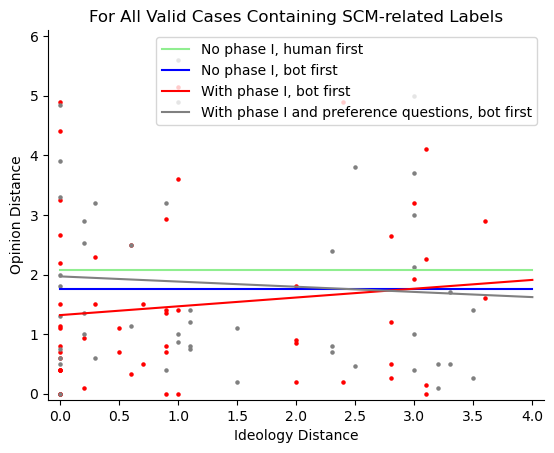

In [20]:
def plot_figure_when_bot_answers_first(each_answer, ax, color, label=None, display_scatter=False):
    bot_answers_first_c2 = each_answer['who_answers_first'] != 1
    bot_first_answer_distances_c2 = each_answer['answer_distance'][bot_answers_first_c2].tolist()
    bot_first_ideology_distances_c2 = each_answer['ideology_distance'][bot_answers_first_c2].tolist()
    m_c2, b_c2 = np.polyfit(x=bot_first_ideology_distances_c2, y=bot_first_answer_distances_c2, deg=1)
    regression_line_x = np.linspace(0, 4, 100)
    regression_line_y_c2 = m_c2 * regression_line_x + b_c2
    if display_scatter:
        ax.scatter(x=bot_first_ideology_distances_c2, y=bot_first_answer_distances_c2, color=color, s=5)
    ax.plot(regression_line_x, regression_line_y_c2, color=color, label=label)

fig, ax = plt.subplots()
ax.set_xlim(-0.1, 4.1)
ax.set_ylim(-0.1, 6.1)

ax.plot([0, 4], [human_first_answer_distance, human_first_answer_distance], color='lightgreen', label="No phase I, human first")
ax.plot([0, 4], [bot_first_answer_distance, bot_first_answer_distance], color='blue', label="No phase I, bot first")
plot_figure_when_bot_answers_first(each_answer[1][each_answer[1]['has_SCM_label']], ax, color='r', label="With phase I, bot first", display_scatter=True)
plot_figure_when_bot_answers_first(each_answer[2][each_answer[2]['has_SCM_label']], ax, color='grey', label="With phase I and preference questions, bot first", display_scatter=True)

ax.set_title("For All Valid Cases Containing SCM-related Labels")
ax.set_xlabel('Ideology Distance')
ax.set_ylabel('Opinion Distance')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
plt.show()

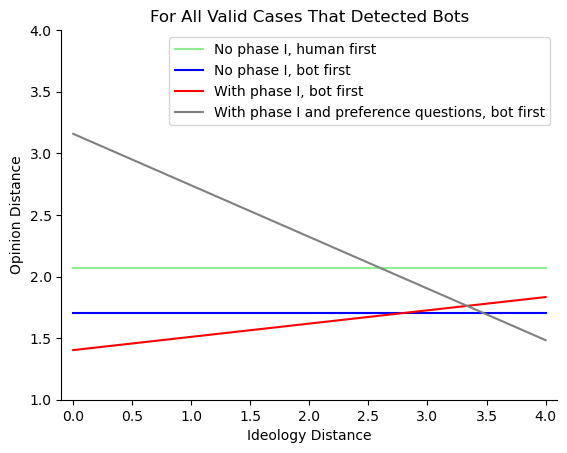

In [212]:
def plot_figure_when_bot_answers_first(each_answer, ax, color, label=None, display_scatter=False):
    bot_answers_first_c2 = each_answer['who_answers_first'] != 1
    bot_first_answer_distances_c2 = each_answer['answer_distance'][bot_answers_first_c2].tolist()
    bot_first_ideology_distances_c2 = each_answer['ideology_distance'][bot_answers_first_c2].tolist()
    m_c2, b_c2 = np.polyfit(x=bot_first_ideology_distances_c2, y=bot_first_answer_distances_c2, deg=1)
    regression_line_x = np.linspace(0, 4, 100)
    regression_line_y_c2 = m_c2 * regression_line_x + b_c2
    if display_scatter:
        ax.scatter(x=bot_first_ideology_distances_c2, y=bot_first_answer_distances_c2, color=color, s=5)
    ax.plot(regression_line_x, regression_line_y_c2, color=color, label=label)

fig, ax = plt.subplots()
ax.set_xlim(-0.1, 4.1)
ax.set_ylim(1, 4)

ax.plot([0, 4], [human_first_answer_distance, human_first_answer_distance], color='lightgreen', label="No phase I, human first")
ax.plot([0, 4], [bot_first_detected_answer_distance, bot_first_detected_answer_distance], color='blue', label="No phase I, bot first")
plot_figure_when_bot_answers_first(each_answer[1][each_answer[1]['detect_first_answering_bot']], ax, color='r', label="With phase I, bot first")
plot_figure_when_bot_answers_first(each_answer[2][each_answer[2]['detect_first_answering_bot']], ax, color='grey', label="With phase I and preference questions, bot first")

ax.set_title('For All Valid Cases That Detected Bots')
ax.set_xlabel('Ideology Distance')
ax.set_ylabel('Opinion Distance')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
plt.show()

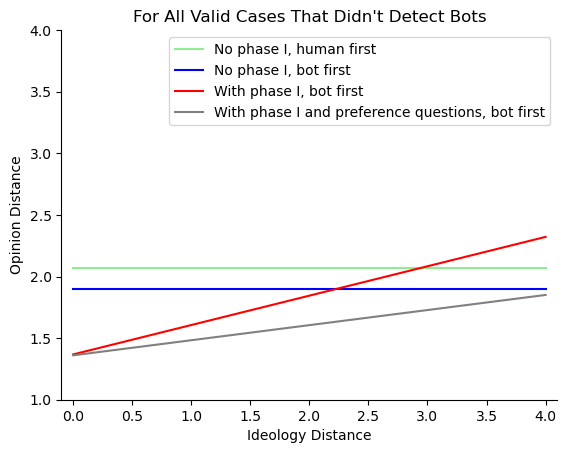

In [214]:
def plot_figure_when_bot_answers_first(each_answer, ax, color, label=None, display_scatter=False):
    bot_answers_first_c2 = each_answer['who_answers_first'] != 1
    bot_first_answer_distances_c2 = each_answer['answer_distance'][bot_answers_first_c2].tolist()
    bot_first_ideology_distances_c2 = each_answer['ideology_distance'][bot_answers_first_c2].tolist()
    m_c2, b_c2 = np.polyfit(x=bot_first_ideology_distances_c2, y=bot_first_answer_distances_c2, deg=1)
    regression_line_x = np.linspace(0, 4, 100)
    regression_line_y_c2 = m_c2 * regression_line_x + b_c2
    if display_scatter:
        ax.scatter(x=bot_first_ideology_distances_c2, y=bot_first_answer_distances_c2, color=color, s=5)
    ax.plot(regression_line_x, regression_line_y_c2, color=color, label=label)

fig, ax = plt.subplots()
ax.set_xlim(-0.1, 4.1)
ax.set_ylim(1, 4)

ax.plot([0, 4], [human_first_answer_distance, human_first_answer_distance], color='lightgreen', label="No phase I, human first")
ax.plot([0, 4], [bot_first_not_detected_answer_distance, bot_first_not_detected_answer_distance], color='blue', label="No phase I, bot first")
plot_figure_when_bot_answers_first(each_answer[1][~each_answer[1]['detect_first_answering_bot']], ax, color='r', label="With phase I, bot first")
plot_figure_when_bot_answers_first(each_answer[2][~each_answer[2]['detect_first_answering_bot']], ax, color='grey', label="With phase I and preference questions, bot first")

ax.set_title("For All Valid Cases That Didn't Detect Bots")
ax.set_xlabel('Ideology Distance')
ax.set_ylabel('Opinion Distance')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
plt.show()